# Winer denoise audio filter

In [1]:
import matplotlib.pyplot as plt
import torch

from cutcutcodec.core.filter.audio.add import FilterAudioAdd
from cutcutcodec.core.filter.audio.cat import FilterAudioCat
from cutcutcodec.core.filter.audio.equation import FilterAudioEquation
from cutcutcodec.core.filter.audio.subclip import FilterAudioSubclip
from cutcutcodec.core.filter.audio.wiener import FilterAudioWiener
from cutcutcodec.core.generation.audio.equation import GeneratorAudioEquation
from cutcutcodec.core.generation.audio.noise import GeneratorAudioNoise

## Create a syntetic noise
In a winer filter, the noise has to be **ergodic**.

In [2]:
# simulate a wite noise plus a 50Hz sector electrical noise
(noise,) = FilterAudioEquation(
    GeneratorAudioNoise(0).out_streams,
    "0.3*fl_0 + 0.2*sin(2*pi*100*t) + 0.1*sin(2*pi*200*t) + 0.1*sin(2*pi*400*t) + 0.05*sin(2*pi*800*t)",
    "0.3*fr_0 + 0.2*cos(2*pi*100*t) + 0.1*cos(2*pi*200*t) + 0.1*cos(2*pi*400*t) + 0.05*cos(2*pi*800*t)",
).out_streams

## Create a syntetic perfect signal

In [3]:
# make a stereo musical note A
(perfect,) = GeneratorAudioEquation(  
    "0.6*sin(2*pi*440*t) + 0.2*sin(2*pi*880*t)",
    "0.6*cos(2*pi*440*t) + 0.2*cos(2*pi*880*t)",
).out_streams
# add 10 seconds of silence at the beginning
(perfect,) = FilterAudioCat(
    [FilterAudioSubclip(GeneratorAudioEquation("0", "0").out_streams, 0, 10).out_streams[0], perfect]
).out_streams

## Add the two signals to make realisic noisy signal

In [4]:
(noisy,) = FilterAudioAdd([perfect, noise]).out_streams

## Use Winer filter to denoised the signal

In [5]:
(noise_sample,) = FilterAudioSubclip([noisy], 0, 5).out_streams  # select 5 second of noise
(denoised,) = FilterAudioWiener(
    [noise_sample, noisy], level=1.0
).out_streams

In [6]:
rate = 8000
noise_frame = noise.snapshot(0, rate, 20*rate)
perfect_frame = perfect.snapshot(0, rate, 20*rate)
noisy_frame = noisy.snapshot(0, rate, 20*rate)
denoised_frame = denoised.snapshot(0, rate, 20*rate)

## Visualise the signal

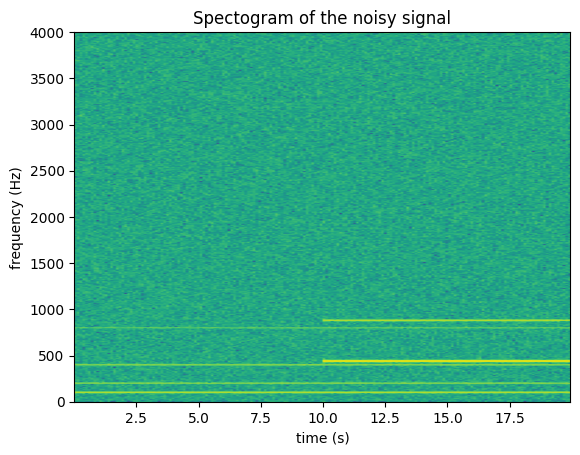

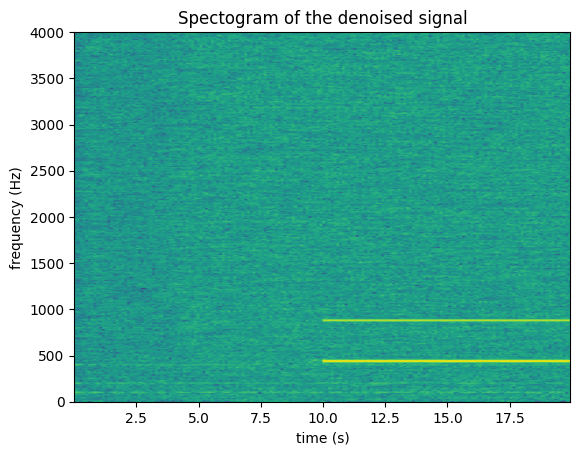

In [7]:
# display noisy frame
plt.title("Spectogram of the noisy signal")
plt.xlabel("time (s)")
plt.ylabel("frequency (Hz)")
plt.specgram(noisy_frame[0], Fs=noisy_frame.rate, NFFT=1024)
plt.show()

# display denoised frame
plt.title("Spectogram of the denoised signal")
plt.xlabel("time (s)")
plt.ylabel("frequency (Hz)")
plt.specgram(denoised_frame[0], Fs=denoised_frame.rate, NFFT=1024)
plt.show()

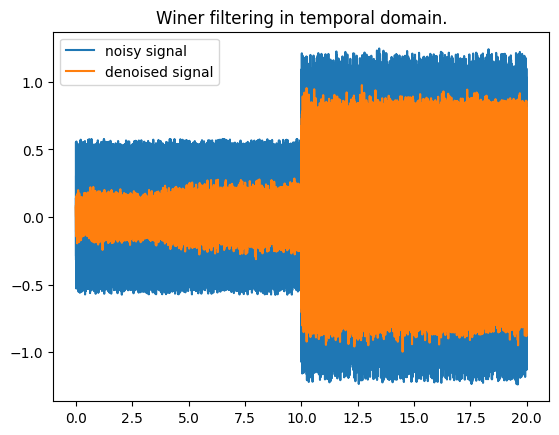

In [8]:
# signal in temporal domains
plt.title("Winer filtering in temporal domain.")
plt.plot(torch.arange(noisy_frame.shape[1]) / noisy_frame.rate, noisy_frame[0], label="noisy signal")
plt.plot(torch.arange(denoised_frame.shape[1]) / denoised_frame.rate, denoised_frame[0], label="denoised signal")
plt.legend()
plt.show()